# Performance Evaluation

In [2]:
from datetime import timedelta
from typing import NamedTuple
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

tud8b = "#EC6500"


class LinearModel(NamedTuple):
    X: any
    Y: any
    model: LinearRegression


plt.rcParams['figure.figsize'] = (12, 8)
#plt.rcParams["figure.autolayout"] = True

experiments = [
    "ExperimentA",
    "ExperimentB",
    "ExperimentC"
]


def load_store(path: str):
    with pd.HDFStore(path) as store:
        return store['results'] if 'results' in store else None


experimentAStore_low_times = load_store('../ExperimentAStore_low_times.h5')
experimentAStore_low_memory = load_store('../ExperimentAStore_low_memory.h5')
experimentAStore_high_times = load_store('../ExperimentAStore_high_times.h5')
experimentAStore_high_memory = load_store('../ExperimentAStore_high_memory.h5')

experimentBStore_low_times = load_store('../ExperimentBStore_low_times.h5')
experimentBStore_low_memory = load_store('../ExperimentBStore_low_memory.h5')
experimentBStore_high_times = load_store('../ExperimentBStore_high_times.h5')
experimentBStore_high_memory = load_store('../ExperimentBStore_high_memory.h5')

experimentB2Store_times = load_store('../ExperimentB2Store_times.h5')

experimentCStore_times = load_store('../ExperimentCStore_times.h5')
experimentCStore_memory = load_store('../ExperimentCStore_memory.h5')

humanTaskNames = {
    "infer": "infer-task",
    "sparql": "sparql-task",
    "buildkb": "buildkb-task",
    "shacl": "shacl-task"
}

taskColors = {
    "infer": "#0083CC",
    "sparql": "#F5A300",
    "buildkb": "#009D81",
    "shacl": "#C9308E"
}

taskOrder = {
    "buildkb": 0,
    "sparql": 1,
    "shacl": 2,
    "infer": 3,
}


def flatten_for_metric(store, metric):
    list_entries = store[[metric]].applymap(
        lambda x: list(map(lambda z: z[1], sorted([(k, x[k]) for k in x], key=lambda y: taskOrder[y[0]]))))
    columns = sorted(store.iloc[0][metric].keys(), key=lambda x: taskOrder[x])

    return pd.DataFrame(
        [x for [x] in list_entries.to_numpy()],
        columns=columns,
        index=list_entries.index
    )

primitives = (int, float)

def save_csv(store, metric, index_label, file):
    flattened = flatten_for_metric(store, metric)

    def to_float(x):
        if type(x) in primitives:
            return x / (1024 * 1024)
        elif x.total_seconds is not None:
            return x.total_seconds()
        else:
            raise 'unknown type'
            

    transformed = flattened.applymap(to_float)
    transformed.to_csv(file, index_label=index_label)


def plot3D(store, task: str, metric: str, frameTransform, zlabel: Optional[str] = None, zmax: Optional[float] = None,
           file: Optional[str] = None):
    frame = pd.DataFrame(store[metric].transform(lambda x: x[task]))
    #display(frame)

    # setup the figure and axes
    fig = plt.figure(figsize=(12, 4))

    x = frame.index.get_level_values(0)
    y = frame.index.get_level_values(1)
    z = np.zeros_like(x)

    dx = dy = 50
    dz = np.array(frameTransform(frame.iloc[:, 0]))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.set_xlabel('generated classes')
        ax.set_ylabel('instances')
        if zlabel is not None:
            ax.set_zlabel(zlabel)
            #ax.zaxis._axinfo['label']['space_factor'] = 20

        if zmax:
            ax.set_zlim([0, zmax])

        ax.bar3d(x, y, z, dx, dy, dz, color=taskColors[task])

    ax1.view_init(elev=30, azim=120)
    ax2.view_init(elev=30, azim=300)
    ax3.view_init(elev=30, azim=210)
    fig.tight_layout(w_pad=5)
    # fig.subplots_adjust(right=1)

    plt.show()

    if file is not None:
        fig.savefig(file, bbox_inches='tight')


def plot_linear_model(task, model: LinearModel, zlabel: str, file: Optional[str]):
    X, Y, lreg = model

    x = X[:, 0]
    y = X[:, 1]
    z = Y

    x_pred = x
    y_pred = y
    xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    predicted = lreg.predict(model_viz)

    plt.style.use('default')

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted, alpha=0.3, color=tud8b)
        ax.plot(x, y, z, color=taskColors[task], zorder=15, linestyle='none', marker='o', alpha=0.6)
        ax.set_xlabel('generated classes')
        ax.set_ylabel('instances')
        ax.set_zlabel(zlabel)

    #ax1.view_init(elev=28, azim=120)
    #ax2.view_init(elev=4, azim=114)
    #ax3.view_init(elev=4, azim=280)
    ax1.view_init(elev=30, azim=120)
    ax2.view_init(elev=30, azim=300)
    ax3.view_init(elev=30, azim=210)
    fig.tight_layout(w_pad=5)

    if file is not None:
        fig.savefig(file, bbox_inches='tight')

    fig


def get_linear_model(metric: str, task: str, metric_transform) -> LinearModel:
    data = experimentCStore[metric].transform(lambda x: x[task]).reset_index()

    X = data[['level_0', 'level_1']].values.reshape(-1, 2)
    Y = data[metric].transform(metric_transform)

    model = LinearRegression()
    model.fit(X, Y)

    return LinearModel(X=X, Y=Y, model=model)


def expC_linear_evaluation(task, metric, zlabel, metric_transform, file: Optional[str]):
    model = get_linear_model(metric, task, metric_transform)
    plot_linear_model(task, model, zlabel, file)
    evaluate_linear_model(model)


def expC_linear_evaluation_time(task):
    plotTime3D(experimentCStore, task, file=f"experimentC_{task}_time.pdf")
    expC_linear_evaluation(
        task=task,
        metric="times",
        zlabel='time [s]',
        metric_transform=lambda x: x.total_seconds(),
        file=f"experimentC_{task}_time_model.pdf"
    )


def expC_linear_evaluation_memory(task):
    plotMemory3D(experimentCStore, task, file=f"experimentC_{task}_memory.pdf")
    expC_linear_evaluation(
        task=task,
        metric="memory",
        zlabel='peak memory usage [MiB]',
        metric_transform=lambda x: x / (1024 * 1024),
        file=f"experimentC_{task}_memory_model.pdf"
    )


def plotTime3D(store, metric, task):
    frame = store[metric].transform(lambda x: x[task])

    # setup the figure and axes
    fig = plt.figure()
    ax1 = fig.add_subplot(121, projection='3d')

    ax1.bar3d(frame)
    plt.show()


def plotTaskComparison(
        store,
        metric,
        frameTransform,
        labelMaker,
        ymax: Optional[float],
        ymin: Optional[float],
        xlabel: Optional[str],
        ylabel: Optional[str],
        fileBaseName: Optional[str]
):
    tasks = store[metric].iloc[0].keys()
    tasks = [task for task in tasks if task in humanTaskNames]
    tasks.sort(key=lambda x: taskOrder.get(x, max(taskOrder.values()) + 1))
    labels = store.index

    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots()

    idx = 0
    for task in tasks:
        frame = frameTransform(store[metric].transform(lambda x: x[task]))
        subfig = ax.bar((x + (idx * width / len(tasks))) - width / 2 + width / len(tasks) / 2, frame,
                        width=width / len(tasks), label=task, color=taskColors[task])
        ax.bar_label(subfig, labels=labelMaker(frame), padding=3)
        #fig.set_yscale('symlog')
        idx = idx + 1

    plt.legend([humanTaskNames[task] for task in tasks])
    ax.set_xticks(x, labels)
    
    oldmin, oldmax = ax.get_ylim()
    if ymax:
        ax.set_ylim([oldmin, ymax])
    if ymin:
        ax.set_ylim([ymin, oldmax])

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    fig.tight_layout()
    plt.show()

    if fileBaseName is not None:
        fig.savefig(f"{fileBaseName}.pdf", bbox_inches='tight')


def plotTaskTimeComparison(store, ymin, ymax, fileBaseName: Optional[str], xlabel: Optional[str]):
    save_csv(store, 'times', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'times',
        lambda frame: frame.astype('timedelta64[ns]').transform(lambda x: x / timedelta(seconds=1)),
        lambda frame: ["{:.2f}s".format(f) for f in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="time [s]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )


def plotTaskMemoryComparison(store, ymin, ymax, fileBaseName: Optional[str], xlabel: Optional[str]):
    save_csv(store, 'memory', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'memory',
        lambda frame: frame.transform(lambda x: x / (1024 * 1024)),
        lambda frame: ["{:.0f}MiB".format(v) for v in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="peak memory usage [MiB]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )


def plotAllStats(store):
    labels = store.index[0:2]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    for idx in labels:
        stats = store.loc[idx]['stats']
        idx = 0
        for key in stats:
            rects = ax.bar((x + (idx * width / len(stats))) - width / 2, stats[key], width, label=key)
            ax.bar_label(rects, padding=10)
            idx = idx + 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(x, labels)
    # ax.legend()

    fig.tight_layout()

    plt.show()


def plotStats(store, idx):
    statsDict = store.loc[idx]['stats']
    plt.bar(*zip(*statsDict.items()))

    all_axes = plt.gcf().get_axes()
    ax = all_axes[0]
    ax.set_yscale('symlog')

    plt.show()


def plotTime3D(store, task, zmax: Optional[float] = None, file: Optional[str] = None):
    plot3D(
        store,
        task,
        metric='times',
        frameTransform=lambda f: f.transform(lambda x: x.total_seconds()),
        zlabel='time [s]',
        zmax=zmax,
        file=file
    )


def plotMemory3D(store, task, zmax: Optional[float] = None, file: Optional[str] = None):
    plot3D(
        store,
        task,
        metric='memory',
        frameTransform=lambda f: f.transform(lambda x: x / (1024 * 1024)),
        zlabel='peak memory usage [MiB]',
        zmax=zmax,
        file=file
    )


def evaluate_linear_model(model: LinearModel):
    X, Y, lreg = model
    print(f"R2: {lreg.score(X, Y)}")
    b1, b2 = lreg.coef_
    print(f"Coefficients: {lreg.coef_}")
    print(f"Intercept: {lreg.intercept_}")

    if b1 > b2:
        print("Classes have stronger influence")
    elif b2 > b1:
        print("Instances have stronger influence")
    else:
        print("Influence is equally strong")

## Quadratic Models

In [16]:
from typing import Any

class PolynomialModel(NamedTuple):
    X: Any
    Y: Any
    poly_reg: PolynomialFeatures
    lin_base: LinearRegression

def plot_quadratic_model(task, model: PolynomialModel, zlabel: str, file: Optional[str]):
    X, Y, poly_reg, lin_base = model

    x = X[:, 0]
    y = X[:, 1]
    z = Y

    x_pred = x
    y_pred = y
    xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    predicted = lin_base.predict(poly_reg.fit_transform(model_viz))

    plt.style.use('default')

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted, alpha=0.3, color=tud8b)
        ax.plot(x, y, z, color=taskColors[task], zorder=15, linestyle='none', marker='o', alpha=0.6)
        ax.set_xlabel('generated classes')
        ax.set_ylabel('instances')
        ax.set_zlabel(zlabel)

    #ax1.view_init(elev=28, azim=120)
    #ax2.view_init(elev=4, azim=114)
    #ax3.view_init(elev=4, azim=280)
    ax1.view_init(elev=30, azim=120)
    ax2.view_init(elev=30, azim=300)
    ax3.view_init(elev=30, azim=210)
    fig.tight_layout(w_pad=5)

    if file is not None:
        fig.savefig(file, bbox_inches='tight')

    fig


def get_quadratic_model(store, metric: str, task: str, metric_transform) -> PolynomialModel:
    data = store[metric].transform(lambda x: x[task]).reset_index()
    
    poly_reg = PolynomialFeatures(degree=2)

    X = data[['level_0', 'level_1']].values.reshape(-1, 2)
    X_poly = poly_reg.fit_transform(X)
    
    Y = data[metric].transform(metric_transform)

    poly_reg.fit(X_poly, Y)
    
    lin_base = LinearRegression(positive=True)
    lin_base.fit(X_poly, Y)

    return PolynomialModel(X=X, Y=Y, poly_reg=poly_reg, lin_base=lin_base)

def evaluate_quadratic_model(model: PolynomialModel):
    X, Y, poly_reg, lin_base = model
    print(f"R2: {lin_base.score(poly_reg.fit_transform(X), Y)}")
    features = poly_reg.get_feature_names_out(["classes", "instances"])
    summands = ' + '.join(map(lambda x: f"{x[0]}*{x[1]}", filter(lambda x: x[0] != 0, zip(lin_base.coef_, features))))
    print(f"{lin_base.intercept_} + {summands}")

def expC_quadratic_evaluation(store, task, metric, zlabel, metric_transform, file: Optional[str]):
    model = get_quadratic_model(store, metric, task, metric_transform)
    plot_quadratic_model(task, model, zlabel, file)
    evaluate_quadratic_model(model)


def expC_quadratic_evaluation_time(task):
    store = experimentCStore_times
    plotTime3D(store, task, file=f"experimentC_{task}_times.pdf")
    expC_quadratic_evaluation(
        store=store,
        task=task,
        metric="times",
        zlabel='time [s]',
        metric_transform=lambda x: x.total_seconds(),
        file=f"experimentC_{task}_times_model.pdf"
    )

In [105]:
plotTime(classesStore)

10     0 days 00:00:00.812281
100    0 days 00:00:00.842802
200    0 days 00:00:00.819462
500    0 days 00:00:00.824602
1000   0 days 00:00:01.004930
Name: time, dtype: timedelta64[ns]

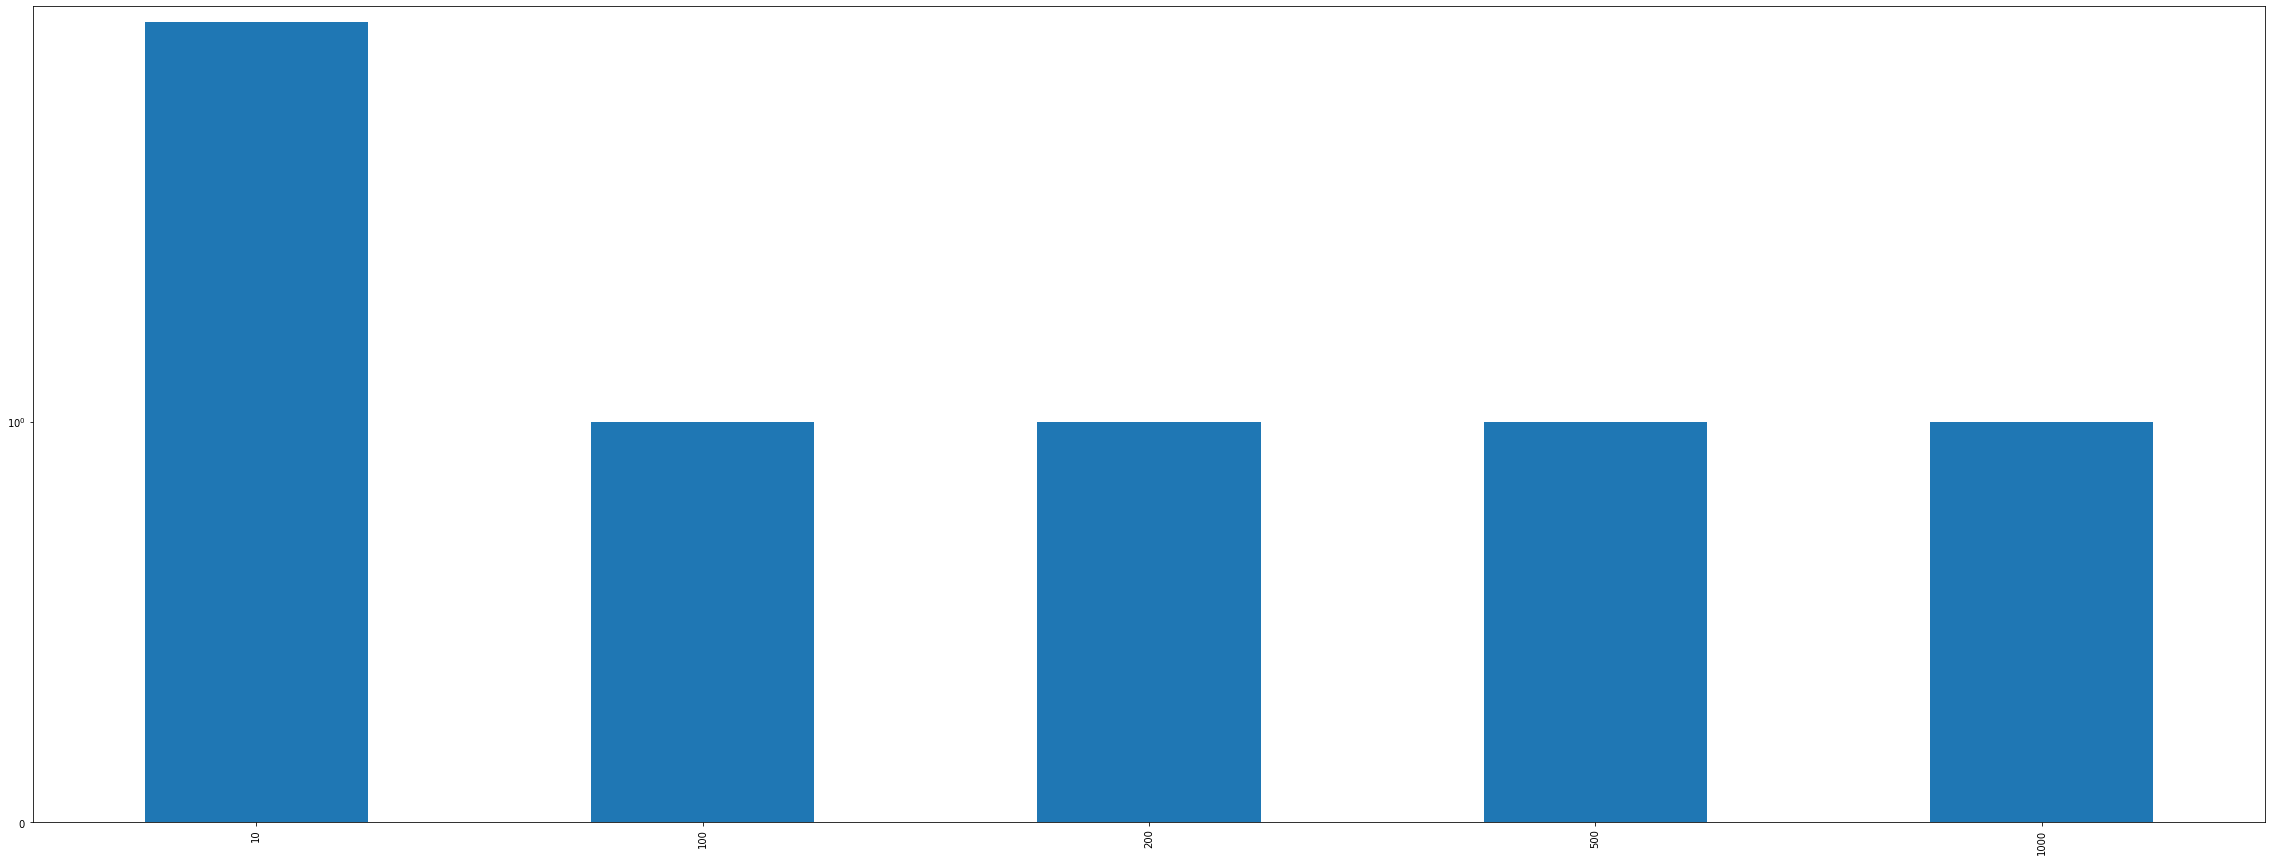

10     0 days 00:00:02.057648
100    0 days 00:00:01.516574
200    0 days 00:00:01.327436
500    0 days 00:00:01.357942
1000   0 days 00:00:01.384977
Name: time, dtype: timedelta64[ns]

In [109]:
plotTime(instancesAndClassesStore)

# Instances Task

* the number of classes does not seem to affect reasoning time much at all
* not that surprising, since the number of instances being queried was low (1)

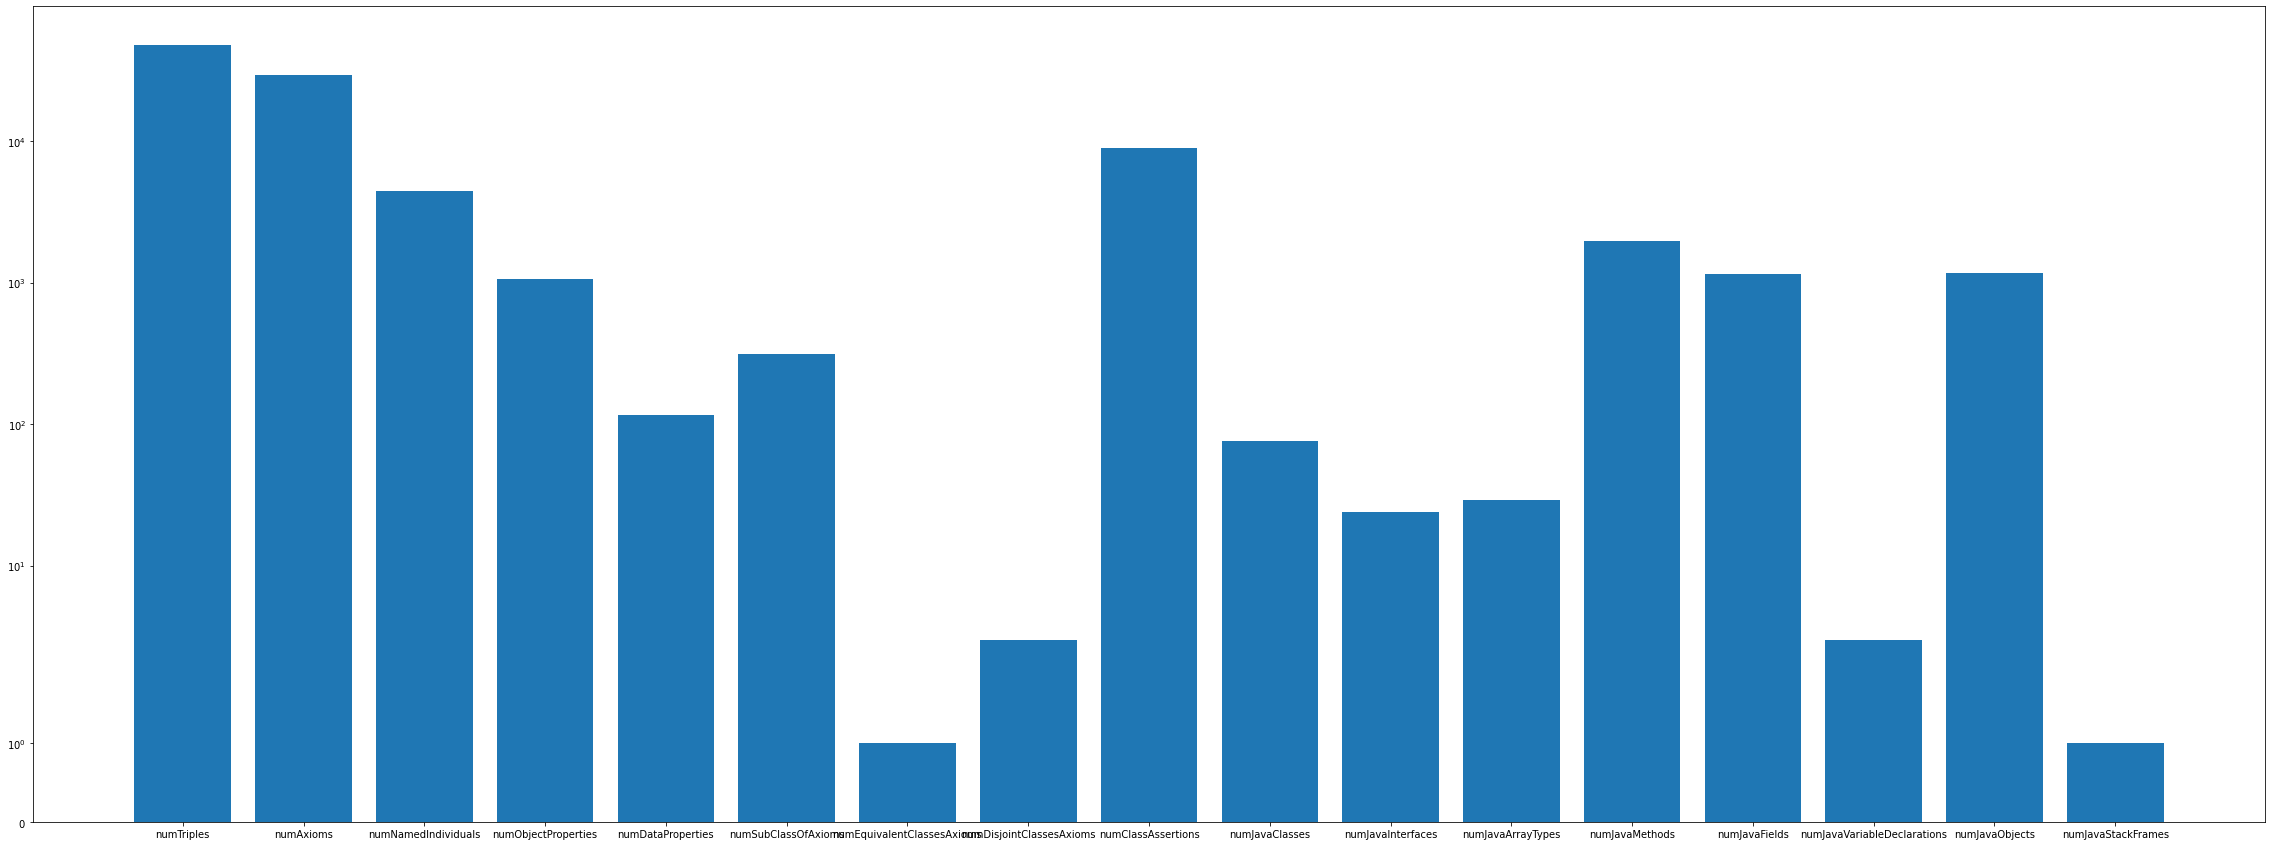

In [102]:
plotStats(instancesStore, 1000)

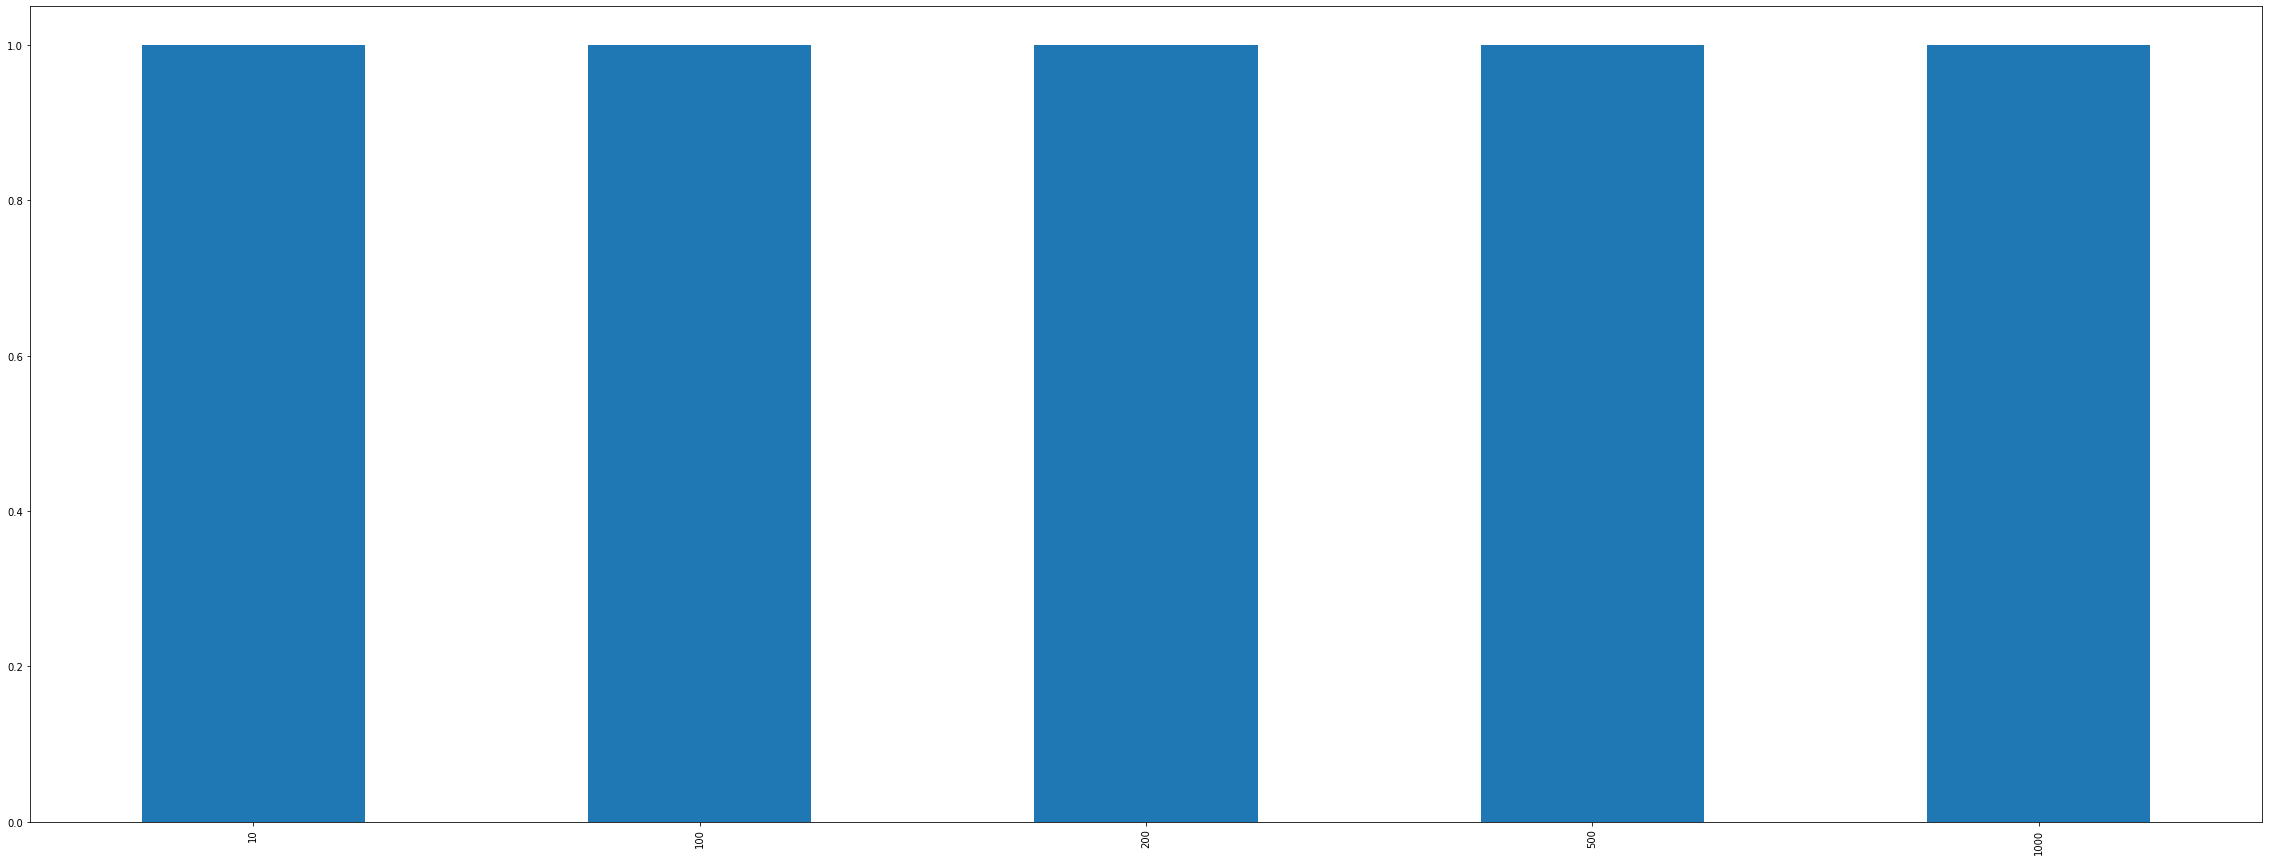

10     0 days 00:00:01.341753
100    0 days 00:00:01.415950
200    0 days 00:00:01.245653
500    0 days 00:00:01.666645
1000   0 days 00:00:01.933969
Name: times, dtype: timedelta64[ns]

In [127]:
plotTime(instancesStore, 'instancesInf')

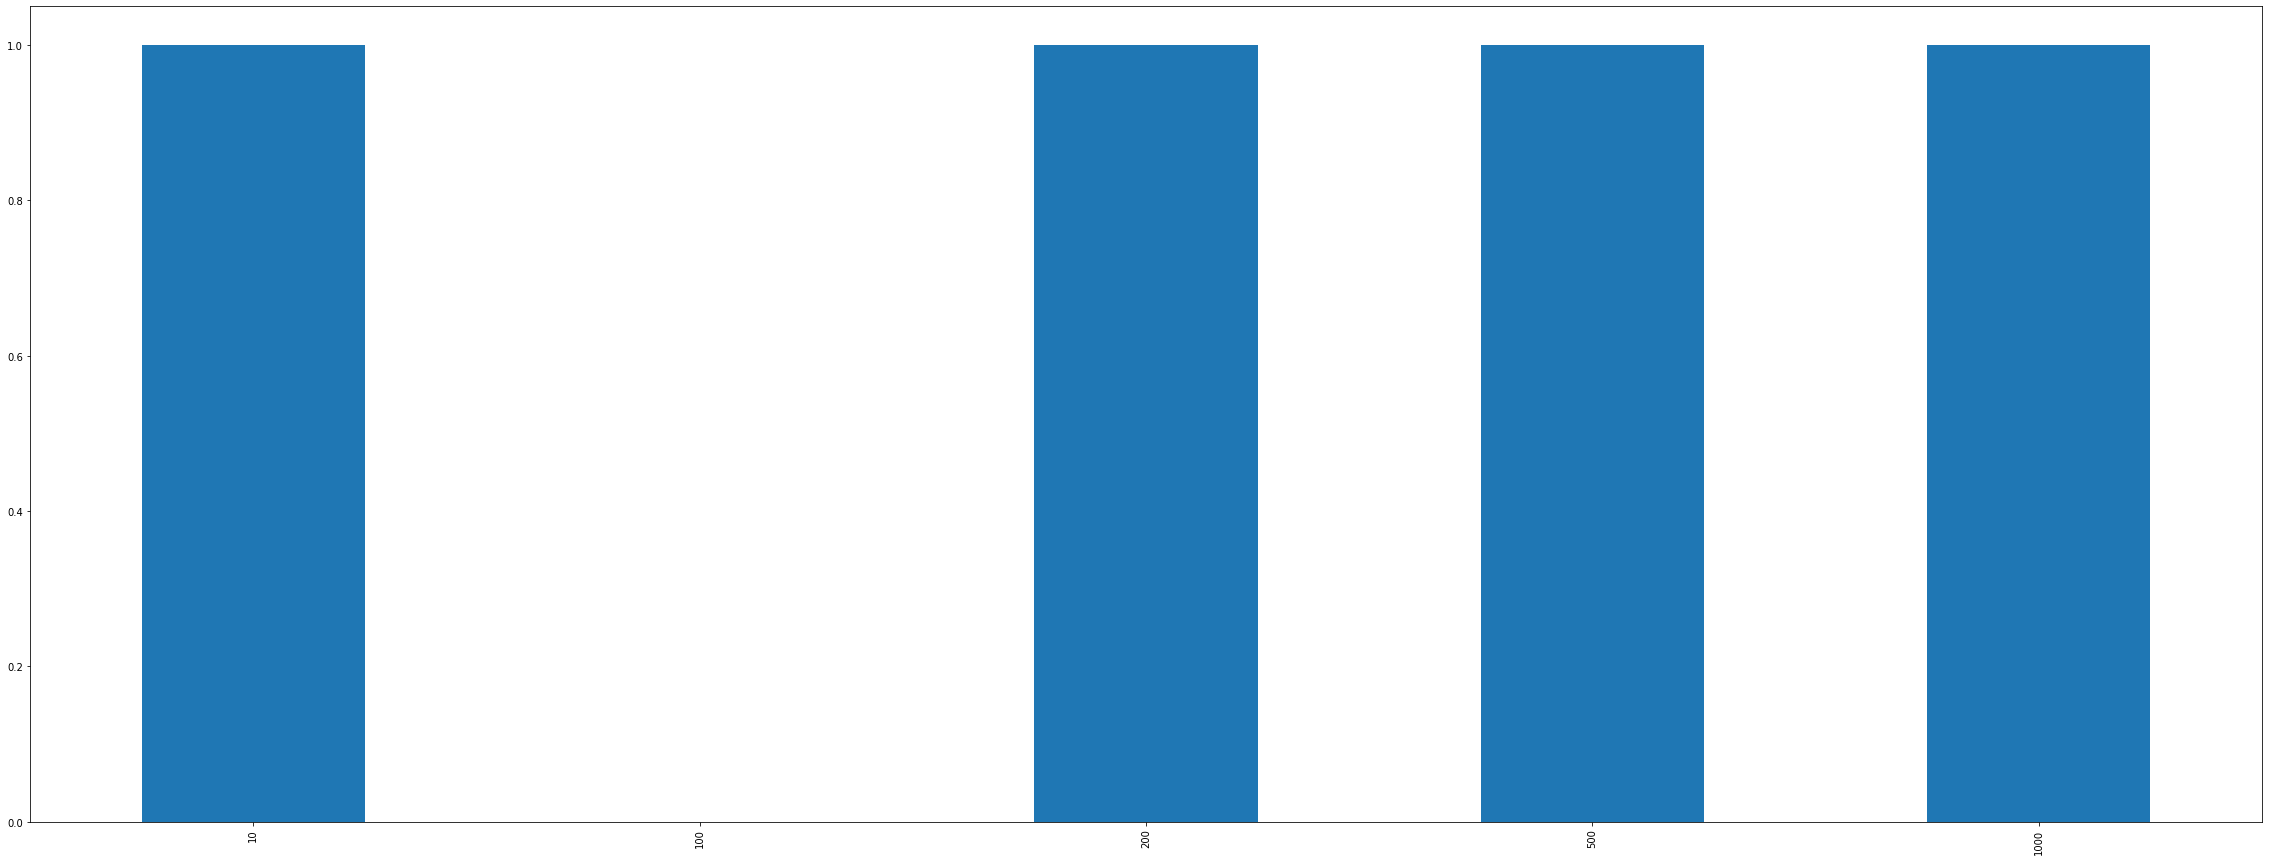

10     0 days 00:00:01.064348
100    0 days 00:00:00.984741
200    0 days 00:00:01.162026
500    0 days 00:00:01.177927
1000   0 days 00:00:01.068332
Name: times, dtype: timedelta64[ns]

In [128]:
plotTime(classesStore, 'instancesInf')

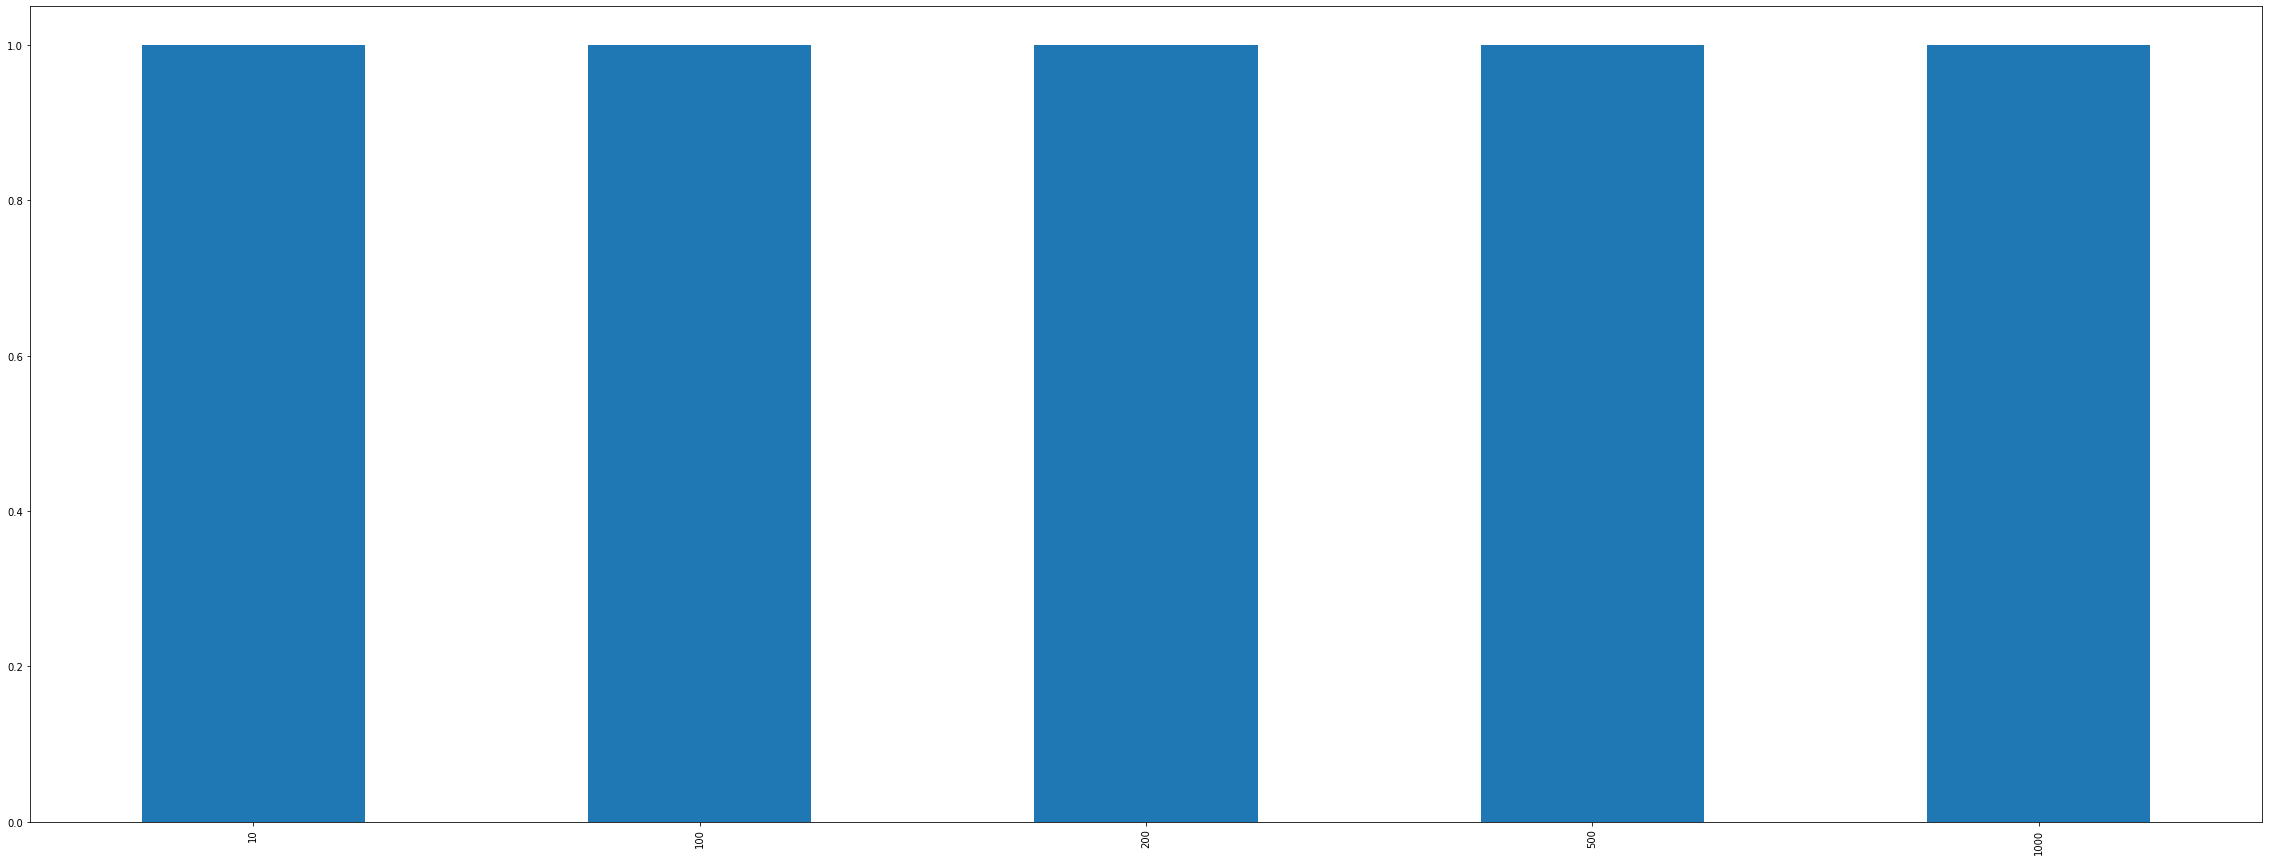

10     0 days 00:00:01.350837
100    0 days 00:00:01.270844
200    0 days 00:00:01.381213
500    0 days 00:00:01.447171
1000   0 days 00:00:01.578023
Name: times, dtype: timedelta64[ns]

In [129]:
plotTime(instancesAndClassesStore, 'instancesInf')

In [134]:
plotTime(instancesAndClassesEqualizedInstanceCountsStore, 'instancesInf')

ValueError: Transform function failed

In [285]:
plotTaskTimeComparison(instancesStore, ymax=2).savefig("instances.jpg")

10      1.341753
100     1.415950
200     1.245653
500     1.666645
1000    1.933969
Name: times, dtype: float64

10      0.259483
100     0.262176
200     0.267139
500     0.241796
1000    0.284551
Name: times, dtype: float64

10      1.064348
100     0.984741
200     1.162026
500     1.177927
1000    1.068332
Name: times, dtype: float64

10      0.213847
100     0.187679
200     0.146644
500     0.141196
1000    0.157120
Name: times, dtype: float64

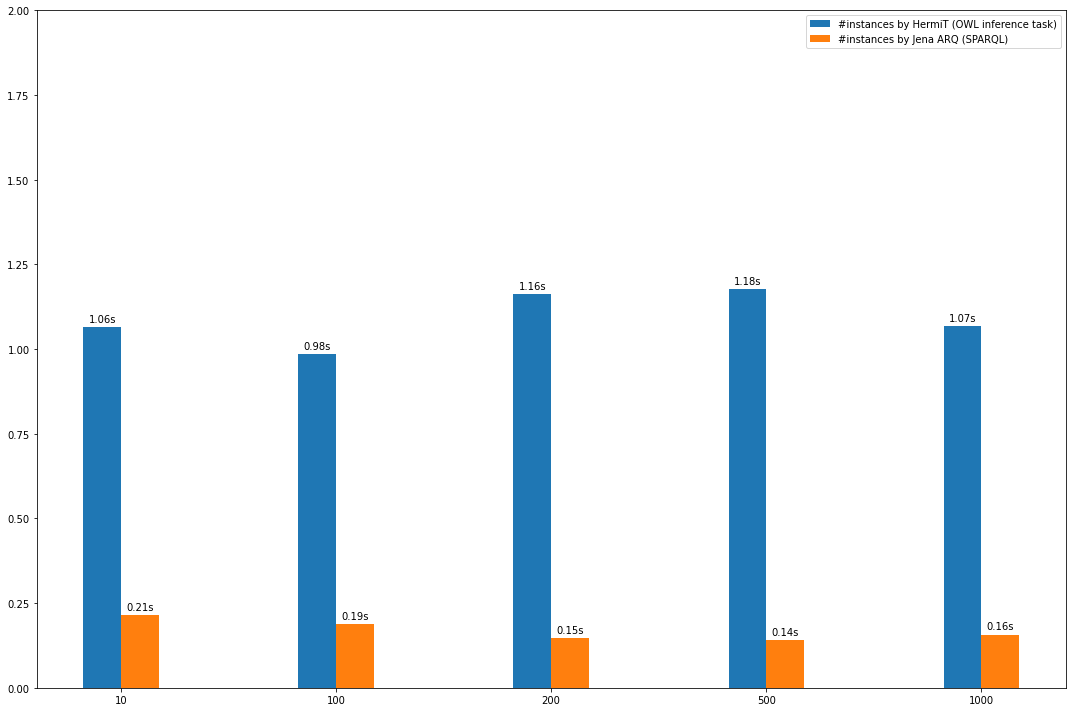

In [286]:
plotTaskTimeComparison(classesStore, ymax=2).savefig('classes.jpg')

10      1.350837
100     1.270844
200     1.381213
500     1.447171
1000    1.578023
Name: times, dtype: float64

10      0.201155
100     0.184803
200     0.150936
500     0.179436
1000    0.179760
Name: times, dtype: float64

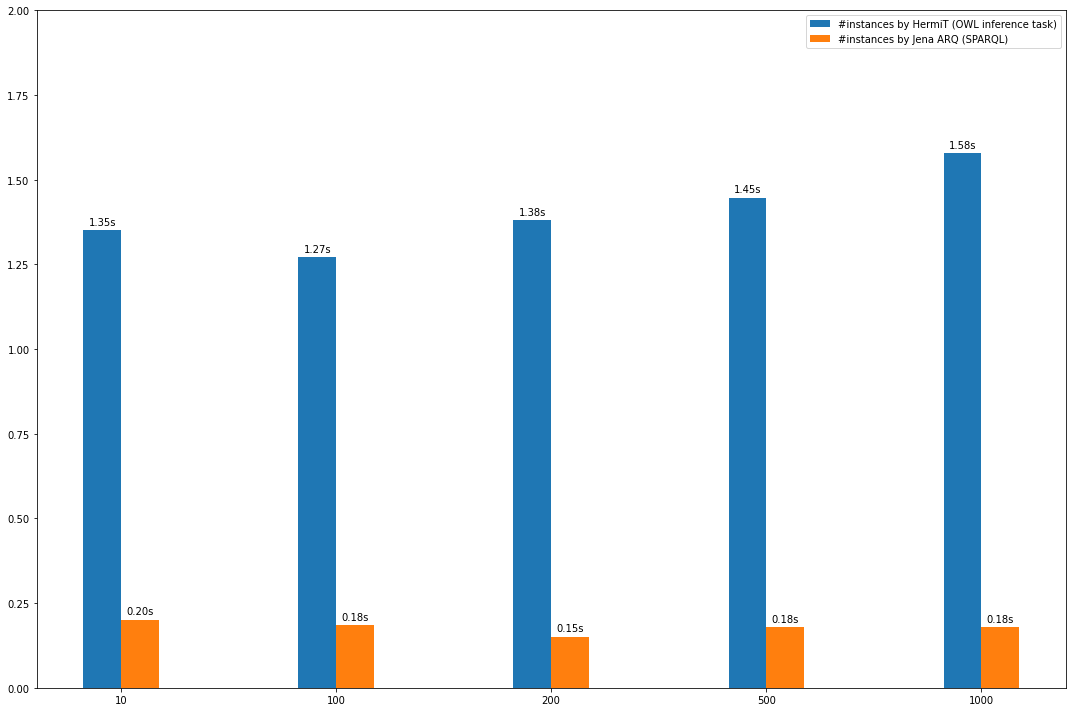

In [287]:
plotTaskTimeComparison(instancesAndClassesStore, ymax=2).savefig('instancesAndClasses.jpg')

<img src=instances.jpg width=600 /> <img src="classes.jpg" width=600/> 
<img src="instancesAndClasses.jpg" width=600/> 

10      1.004985
100     1.924329
200     3.192536
500     8.382650
1000    8.284960
Name: times, dtype: float64

10      0.148689
100     0.134031
200     0.107844
500     0.104279
1000    0.103185
Name: times, dtype: float64

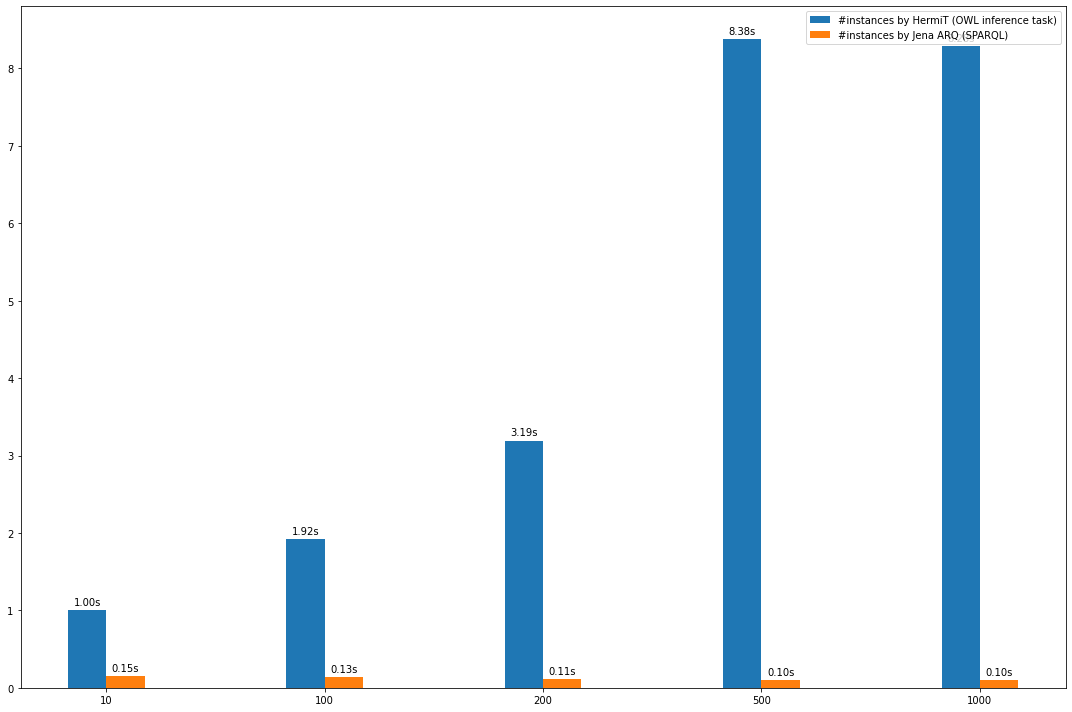

In [310]:
plotTaskTimeComparison(instancesAndClassesEqualizedInstanceCountsStore, ymax=None).savefig(
    'instancesAndClassesEqualizedInstanceCounts.jpg')

In [326]:
#plotTime3D('instancesInf')

times
100  100  0 days 00:00:03.158049
     200  0 days 00:00:02.644085
     300  0 days 00:00:02.516693
     400  0 days 00:00:02.531946
     500  0 days 00:00:03.837904
...                          ...
1000 600  0 days 00:00:16.824974
     700  0 days 00:00:22.427706
     800  0 days 00:00:32.343030
     900  0 days 00:00:48.056326
     1000 0 days 00:00:52.446649

[100 rows x 1 columns]

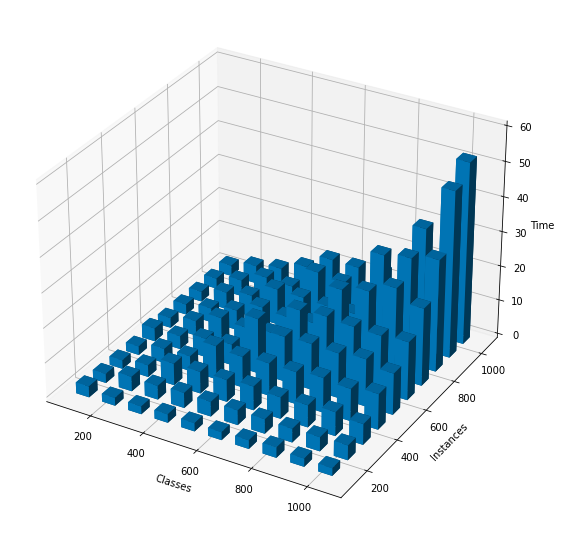

In [397]:
time3D('instancesInf', zmax=60)

times
100  100  0 days 00:00:00.204955
     200  0 days 00:00:00.167803
     300  0 days 00:00:00.155735
     400  0 days 00:00:00.157916
     500  0 days 00:00:00.233195
...                          ...
1000 600  0 days 00:00:00.149386
     700  0 days 00:00:00.151618
     800  0 days 00:00:00.150045
     900  0 days 00:00:00.172715
     1000 0 days 00:00:00.204742

[100 rows x 1 columns]

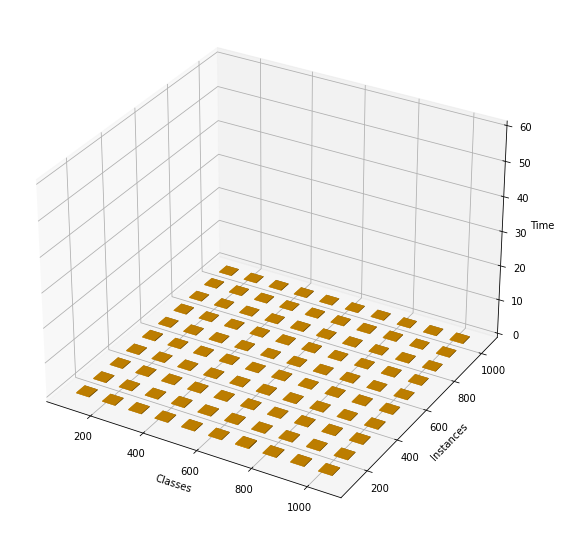

In [396]:
time3D('instancesSparql', zmax=60)

In [395]:
time3D('buildkb', zmax=60)

times
100  100  0 days 00:00:05.297562
     200  0 days 00:00:06.227938
     300  0 days 00:00:05.714390
     400  0 days 00:00:05.877687
     500  0 days 00:00:06.765099
...                          ...
1000 600  0 days 00:00:15.489749
     700  0 days 00:00:20.406993
     800  0 days 00:00:21.618407
     900  0 days 00:00:27.032216
     1000 0 days 00:00:31.222250

[100 rows x 1 columns]

# Experiment A

## Low

100     0.648675
200     0.684549
300     0.804097
400     0.776081
500     0.917525
600     0.811966
700     0.859946
800     0.924889
900     0.842357
1000    0.905832
Name: times, dtype: float64

100     0.002244
200     0.003002
300     0.003264
400     0.004389
500     0.004072
600     0.004691
700     0.004620
800     0.005522
900     0.005336
1000    0.005802
Name: times, dtype: float64

100     0.336591
200     0.421788
300     0.418796
400     0.447869
500     0.518628
600     0.521302
700     0.568645
800     0.628483
900     0.621356
1000    0.784858
Name: times, dtype: float64

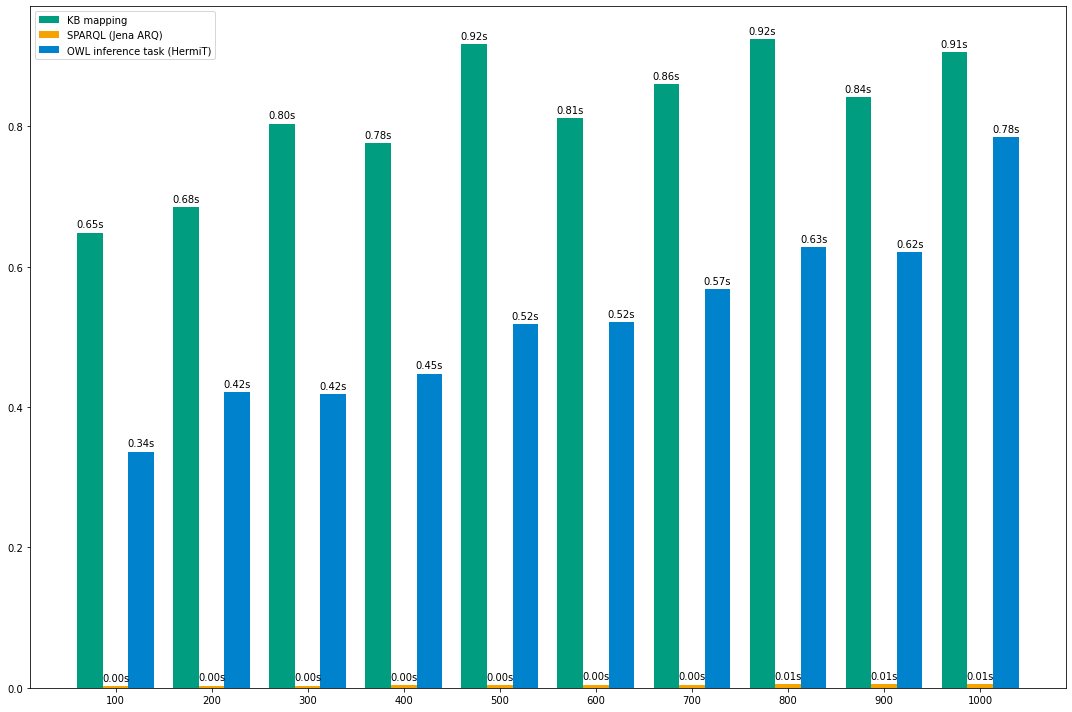

In [7]:
plotTaskTimeComparison(experimentAStore, ymax=None, file="experimentATime.pdf")

100     472.491069
200     469.377061
300     485.285886
400     466.793811
500     470.445807
600     477.990863
700     527.589977
800     515.371117
900     502.000722
1000    509.499951
Name: memory, dtype: float64

100     429.381612
200     389.847386
300     342.750862
400     316.570763
500     348.706189
600     364.007372
700     413.258325
800     376.488867
900     442.539745
1000    416.869012
Name: memory, dtype: float64

100     519.753644
200     574.683893
300     569.063120
400     593.865785
500     587.859534
600     600.117253
700     601.786501
800     594.508807
900     592.894406
1000    592.259058
Name: memory, dtype: float64

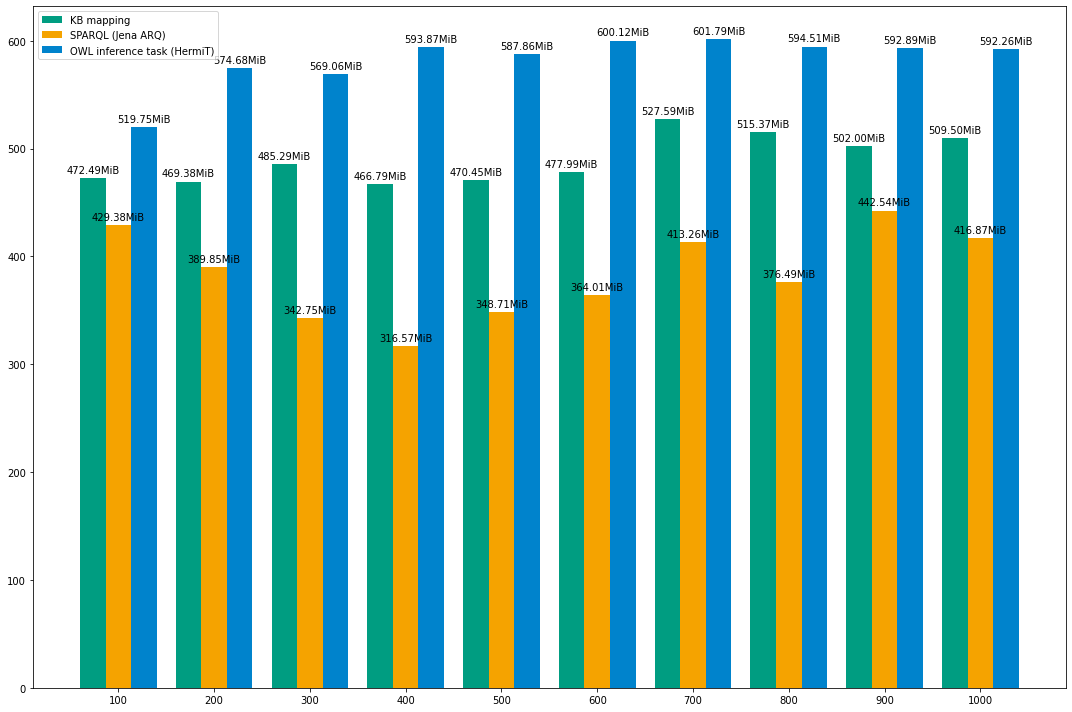

In [6]:
plotTaskMemoryComparison(experimentAStore, ymax=None, file="experimentAMemory.pdf")

# Experiment B

100     0.727232
200     0.834851
300     0.864321
400     0.811635
500     0.825300
600     1.047023
700     1.006244
800     0.852024
900     1.644762
1000    1.095865
Name: times, dtype: float64

100     0.002065
200     0.001728
300     0.002195
400     0.001997
500     0.001626
600     0.002095
700     0.001954
800     0.002263
900     0.001540
1000    0.001795
Name: times, dtype: float64

100     0.334799
200     0.354168
300     0.306347
400     0.331938
500     0.337881
600     0.326032
700     0.326688
800     0.285891
900     0.311712
1000    0.338488
Name: times, dtype: float64

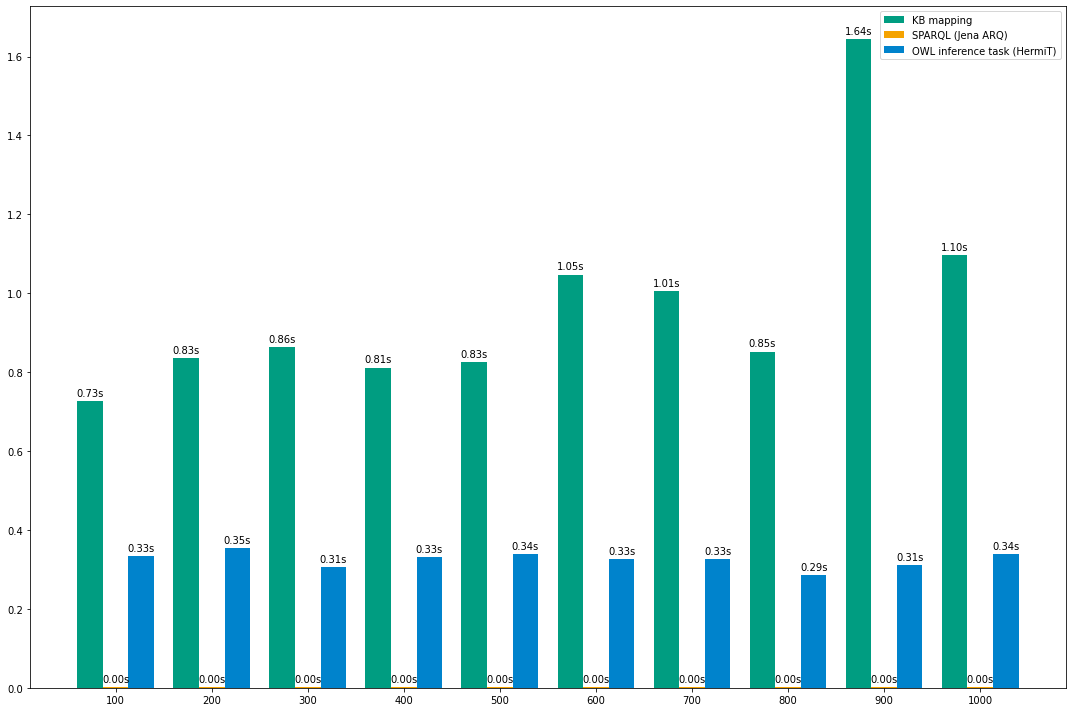

In [8]:
plotTaskTimeComparison(experimentBStore, ymax=None, file="experimentBTime.pdf")

In [9]:
plotTaskMemoryComparison(experimentBStore, ymax=None, file="experimentBMemory.pdf")

100     462.683682
200     492.163126
300     534.485414
400     580.825023
500     535.499219
600     601.447713
700     620.438206
800     641.904065
900     683.019550
1000    669.485898
Name: memory, dtype: float64

100     306.858745
200     366.591283
300     430.675345
400     488.690273
500     490.555153
600     494.675246
700     620.057384
800     583.210292
900     580.300508
1000    606.355104
Name: memory, dtype: float64

100     542.026968
200     582.802965
300     577.536014
400     599.152170
500     618.151756
600     623.776498
700     612.872945
800     637.617998
900     693.177692
1000    655.340437
Name: memory, dtype: float64

# Experiment C

In [32]:
plotTaskTimeComparison(experimentCStore, ymax=None)

100     2.934215
200     2.937356
300     3.106538
400     3.203142
500     3.668164
600     3.386013
700     3.439600
800     3.796354
900     3.621722
1000    3.737403
Name: times, dtype: float64

100     0.170300
200     0.171300
300     0.169909
400     0.154629
500     0.159171
600     0.138230
700     0.190946
800     0.235506
900     0.150686
1000    0.142637
Name: times, dtype: float64

100     2.256363
200     2.204311
300     2.054087
400     2.070056
500     1.951852
600     2.213180
700     2.226028
800     2.147958
900     1.939681
1000    2.675947
Name: times, dtype: float64

In [33]:
plotTaskMemoryComparison(experimentCStore, ymax=None)

100     151.626129
200     150.971977
300     155.736862
400     149.366127
500     161.256004
600     165.096565
700     166.198280
800     168.753853
900     175.423691
1000    172.166412
Name: memory, dtype: float64

100     161.789391
200     164.844765
300     175.682549
400     150.260925
500     176.637413
600     175.187096
700     181.354179
800     182.642502
900     183.689270
1000    197.426079
Name: memory, dtype: float64

100     295.559334
200     231.880501
300     236.684364
400     222.089127
500     305.191399
600     299.422874
700     257.500214
800     291.762329
900     278.048882
1000    288.534554
Name: memory, dtype: float64

# Experiment D

100      3.957248
200      4.860557
300      5.434780
400      5.036150
500     14.842018
600     10.213999
700      7.231588
800      8.302391
900     11.009941
1000     8.430885
Name: times, dtype: float64

100     0.208658
200     0.149146
300     0.143071
400     0.181397
500     0.220632
600     0.196901
700     0.119363
800     0.146279
900     0.160066
1000    0.149408
Name: times, dtype: float64

100      3.350667
200      5.004210
300      5.595117
400      7.188337
500     23.834647
600     12.496149
700     10.823168
800     11.271466
900     12.541142
1000    11.252985
Name: times, dtype: float64

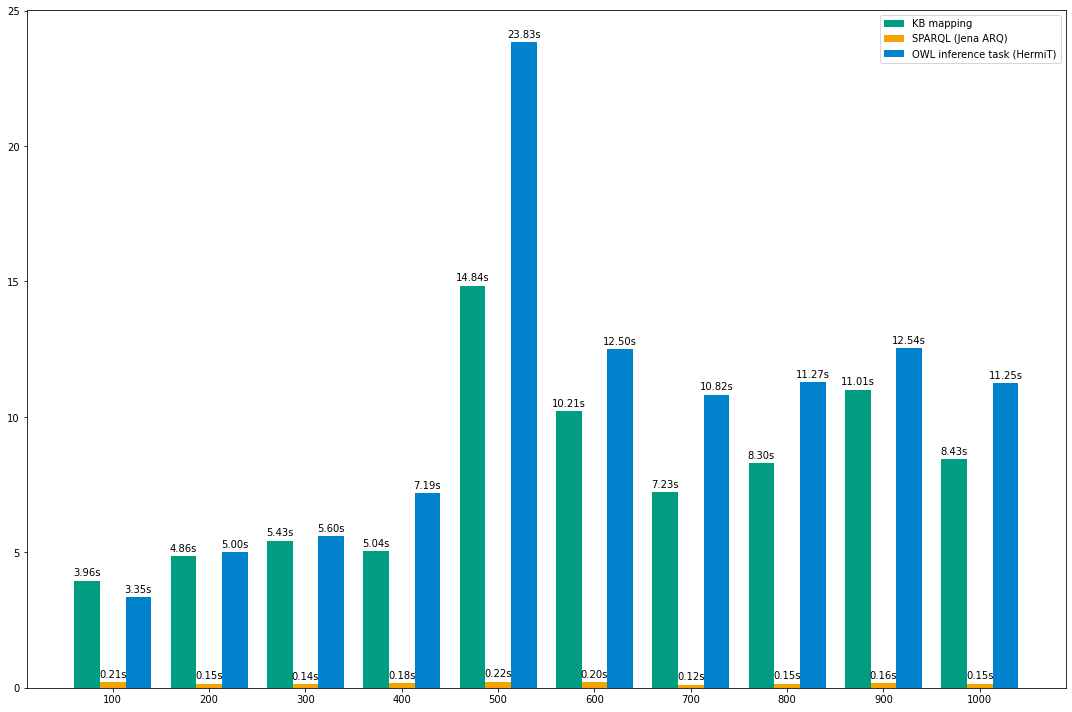

In [34]:
plotTaskTimeComparison(experimentDStore, ymax=None)

In [2]:
plotTaskMemoryComparison(experimentDStore, ymax=None)

100     156.130295
200     185.988899
300     213.999596
400     194.135757
500     258.734787
600     310.626060
700     332.709404
800     365.538536
900     338.854195
1000    466.689873
Name: memory, dtype: float64

100     194.537598
200     196.957588
300     209.941376
400     231.458054
500     285.178940
600     326.053673
700     363.448341
800     355.172783
900     387.167862
1000    366.297707
Name: memory, dtype: float64

100     364.851555
200     376.826584
300     480.243652
400     523.255394
500     747.411140
600     717.092896
700     615.550781
800     690.150253
900     748.525246
1000    672.329041
Name: memory, dtype: float64

# Experiment E

## buildkb

In [17]:
plotTime3D(experimentEStore, 'buildkb', file="experimentC_buildkb_time.pdf")

times
100  100  0 days 00:00:03.268463
     200  0 days 00:00:03.199849
     300  0 days 00:00:03.203557
     400  0 days 00:00:03.381148
     500  0 days 00:00:03.797558
...                          ...
1000 600  0 days 00:00:08.884933
     700  0 days 00:00:10.566074
     800  0 days 00:00:13.296956
     900  0 days 00:00:14.694561
     1000 0 days 00:00:18.827296

[100 rows x 1 columns]

memory
100  100   165431696.0
     200   184549104.0
     300   163086040.0
     400   189190376.0
     500   164431328.0
...                ...
1000 600   489845184.0
     700   460326032.0
     800   438169096.0
     900   555283040.0
     1000  487513176.0

[100 rows x 1 columns]

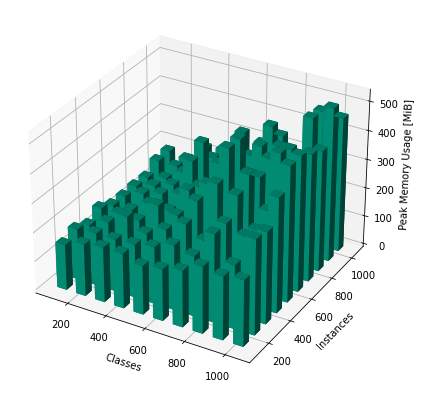

In [18]:
plotMemory3D(experimentEStore, 'buildkb', file="experimentC_buildkb_memory.pdf")

## sparql

times
100  100  0 days 00:00:00.176711
     200  0 days 00:00:00.139195
     300  0 days 00:00:00.137054
     400  0 days 00:00:00.142152
     500  0 days 00:00:00.268619
...                          ...
1000 600  0 days 00:00:00.135144
     700  0 days 00:00:00.179441
     800  0 days 00:00:00.130493
     900  0 days 00:00:00.121953
     1000 0 days 00:00:00.171971

[100 rows x 1 columns]

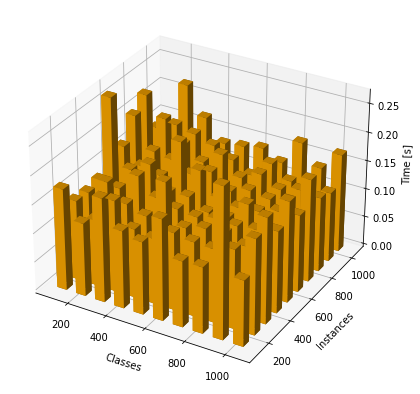

In [20]:
plotTime3D(experimentEStore, 'sparql', file="experimentC_sparql_time.pdf")

memory
100  100   168721584.0
     200   199074336.0
     300   167118144.0
     400   170437568.0
     500   168499280.0
...                ...
1000 600   403450872.0
     700   468169912.0
     800   500103952.0
     900   585692536.0
     1000  552935416.0

[100 rows x 1 columns]

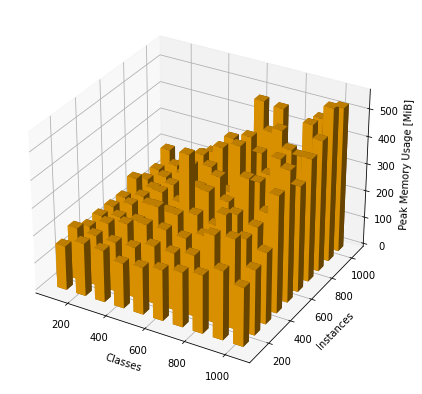

In [19]:
plotMemory3D(experimentEStore, 'sparql', file="experimentC_sparql_memory.pdf")

## infer

times
100  100  0 days 00:00:03.116223
     200  0 days 00:00:04.282921
     300  0 days 00:00:03.599087
     400  0 days 00:00:03.826692
     500  0 days 00:00:05.157594
...                          ...
1000 600  0 days 00:00:17.140993
     700  0 days 00:00:19.745774
     800  0 days 00:00:27.779973
     900  0 days 00:00:41.541505
     1000 0 days 00:00:44.362686

[100 rows x 1 columns]

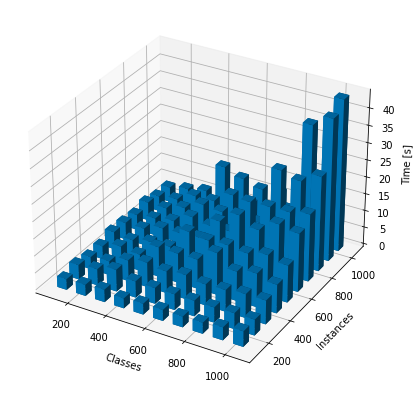

In [21]:
plotTime3D(experimentEStore, 'infer', file="experimentC_infer_time.pdf")

plotMemory3D(experimentEStore, 'infer', file="experimentC_infer_memory.pdf")

# REDO

## Experiment A

### Low

In [44]:
plotTaskTimeComparison(experimentAStore_low_times, ymin=None, ymax=None, fileBaseName="experimentA_low_times", xlabel="C₀ instances")

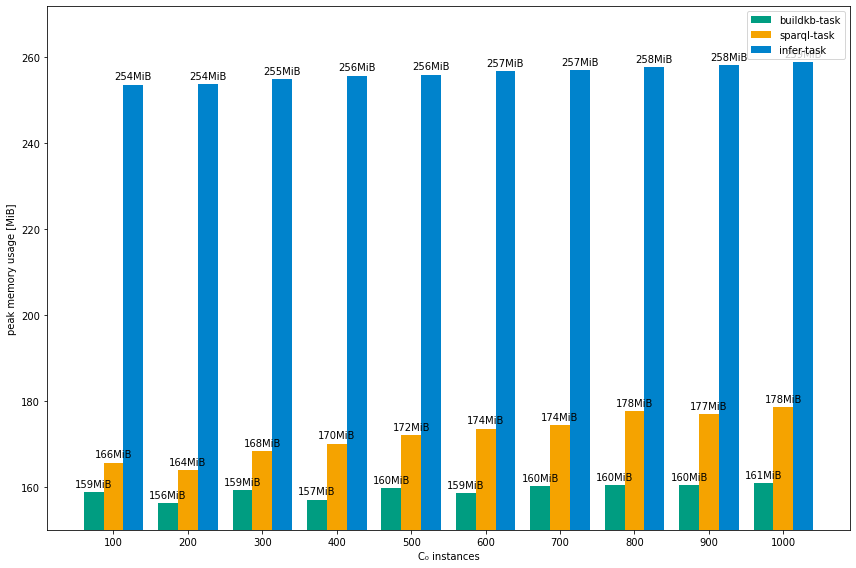

In [28]:
plotTaskMemoryComparison(experimentAStore_low_memory, ymax=None, ymin=150, fileBaseName="experimentA_low_memory", xlabel="C₀ instances")

### High

In [560]:
plotTaskTimeComparison(experimentAStore_high_times, ymax=None, fileBaseName="experimentA_high_times",
                       xlabel="C₀ instances")

## Experiment B

### Low

In [46]:
plotTaskTimeComparison(experimentBStore_low_times, ymin=None, ymax=None, fileBaseName="experimentB_low_times", xlabel="generated classes")

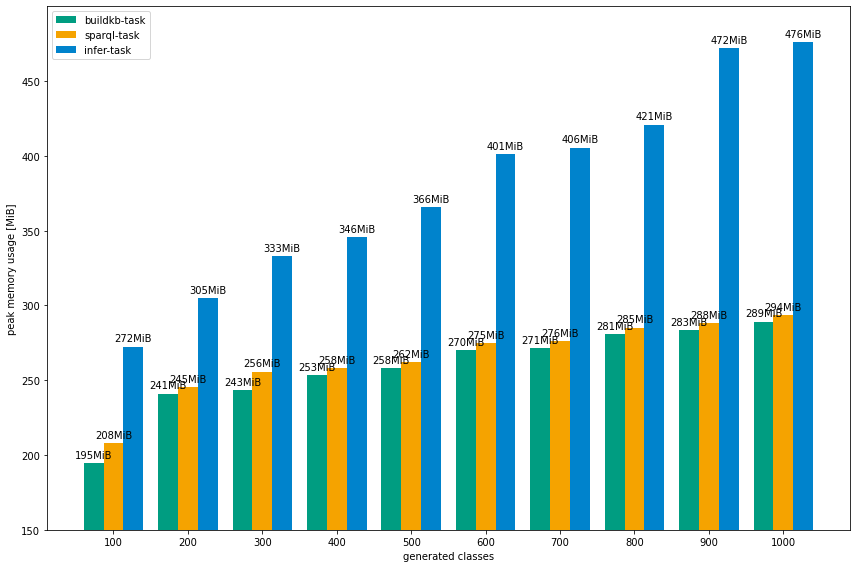

In [32]:
plotTaskMemoryComparison(experimentBStore_low_memory, ymin=150, ymax=None, fileBaseName="experimentB_low_memory", xlabel="generated classes")

### High

In [439]:
plotTaskTimeComparison(experimentBStore_high_times, ymax=None, file="experimentBTime_high_times.pdf",
                       xlabel="generated classes")

### B2

In [58]:
frame = experimentB2Store_times.applymap(lambda x: x['infer'].total_seconds())

data = frame.reset_index()

poly_reg = PolynomialFeatures(degree=2)
X = data[['index']].values
X_poly = poly_reg.fit_transform(X)
Y = data[['times']]
poly_reg.fit(X_poly, Y)
lin_base = LinearRegression(positive=True)
lin_base.fit(X_poly, Y)

predY = pd.DataFrame(
    lin_base.predict(poly_reg.fit_transform(X)),
    index=frame.index,
    columns=['interpolation']
)

simplePredY = pd.DataFrame(
    np.array([
        [0.000038 * (x * 100) ** 2] for x in range(1, 16)  #[x**(0.11*x)] for x in range(1, 16) #  #
    ]),
    index=frame.index,
    columns=['simple-interpolation']
)

frame.rename(columns={'times': 'infer-task'}, inplace=True)
ax = frame.plot.bar(color=taskColors['infer'])
ax.set_xlabel("generated classes")
ax.set_ylabel("time [s]")
ax.get_figure().savefig("experimentB2_times.pdf", bbox_inches='tight')

frame.to_csv("experimentB2_times.csv", index_label="Generated Classes")
#ax = frame.plot.bar()
# predY.plot(ax=ax)
# simplePredY.plot(ax=ax)

# display(poly_reg.powers_)
# display(lin_base.coef_)
# display(lin_base.score(poly_reg.fit_transform(X), Y))

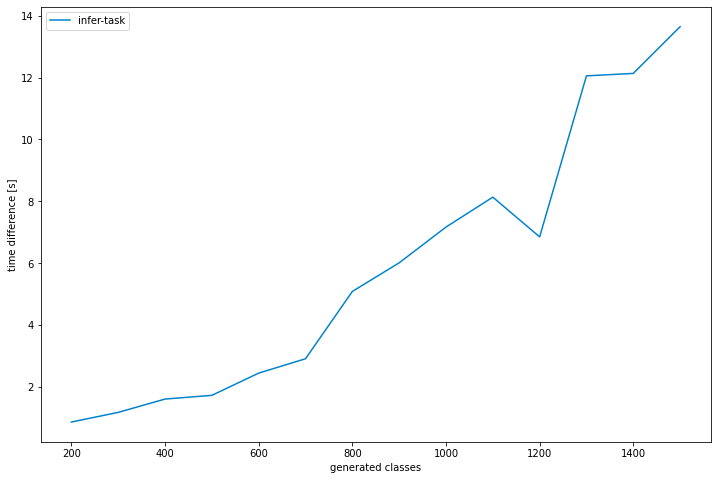

In [60]:
diffFrame = frame.diff()

ax = diffFrame.plot(color=taskColors['infer'])
ax.set_xlabel("generated classes")
ax.set_ylabel("time difference [s]")
ax.get_figure().savefig("experimentB2_times_diff.pdf", bbox_inches='tight')

diffFrame.to_csv("experimentB2_times_diff.csv", index_label="Generated Classes")

<AxesSubplot:>

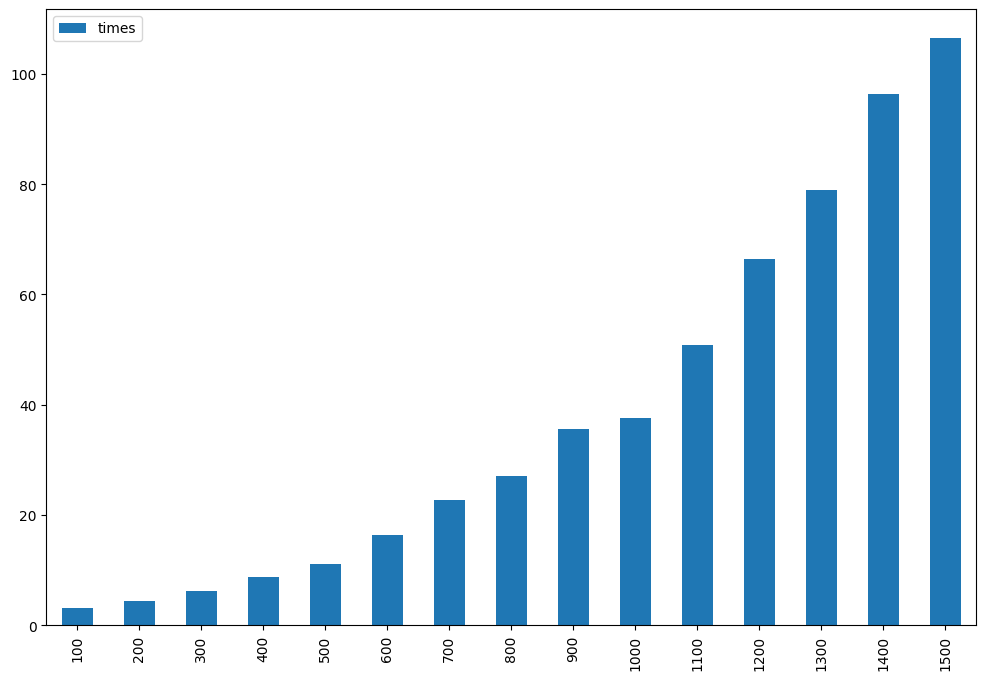

In [673]:
experimentB2Store_times = load_store('../ExperimentB2Store_times.h5')
frame = experimentB2Store_times.applymap(lambda x: x['infer'].total_seconds())
frame.plot.bar()

## Experiment C

### Buildkb

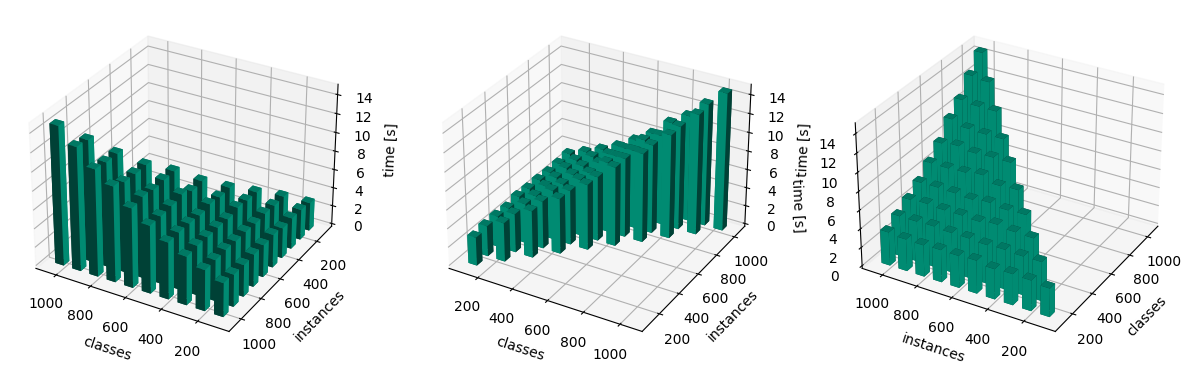

R2: 0.9806762832879817
Coefficients: [0.01130954 0.00035532]
Intercept: 1.6866911999999994
Classes have stronger influence


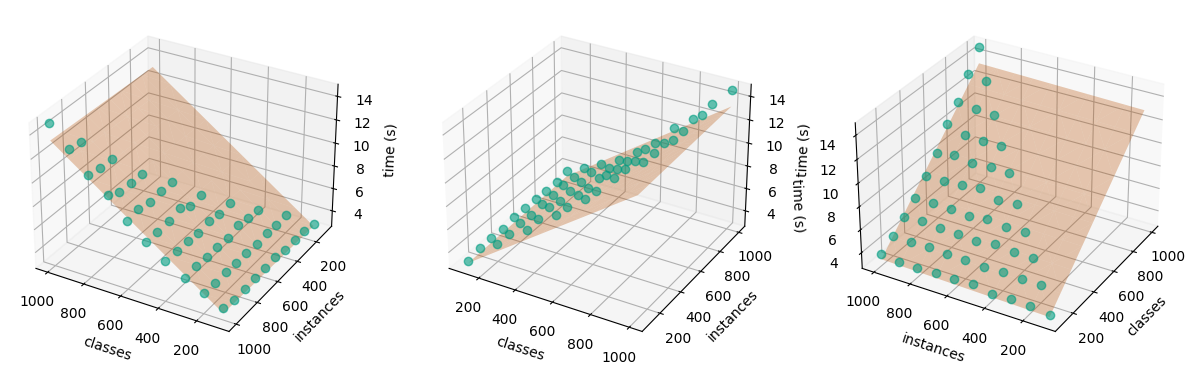

In [355]:
expC_linear_evaluation_time("buildkb")

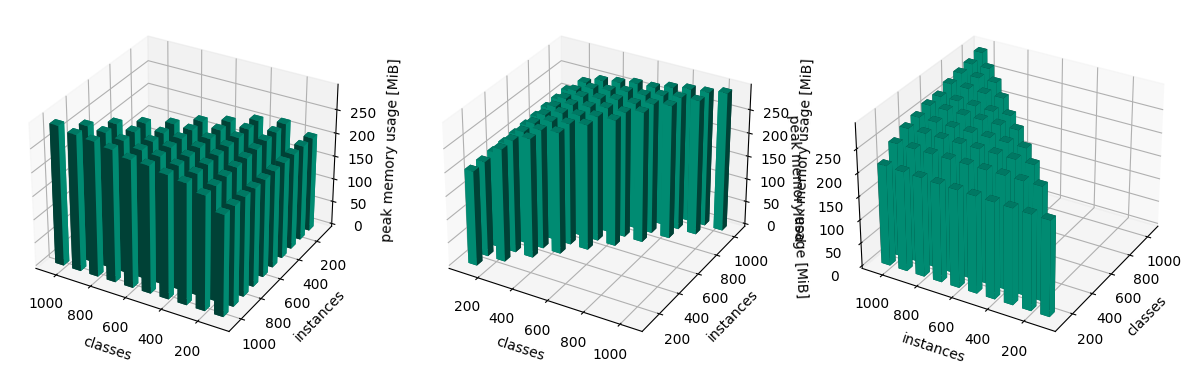

R2: 0.8442293766335772
Coefficients: [0.09284819 0.00536926]
Intercept: 212.51878450181752
Classes have stronger influence


In [410]:
expC_linear_evaluation_memory("buildkb")

### SPARQL

R2: 0.15019972247291147
Coefficients: [-2.07246061e-05  8.03369697e-06]
Intercept: 0.1328547090909091
Instances have stronger influence


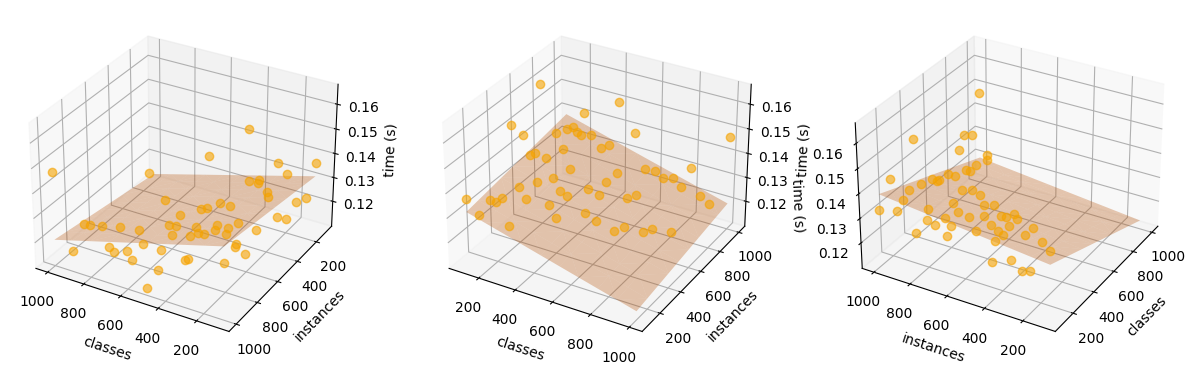

In [358]:
expC_linear_evaluation_time("sparql")

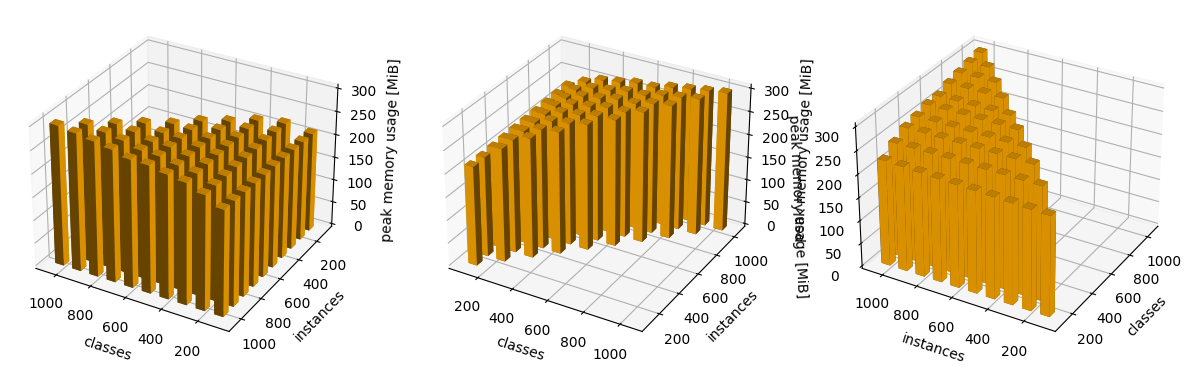

R2: 0.8966349421047035
Coefficients: [0.08548737 0.00560257]
Intercept: 221.50364715113784
Classes have stronger influence


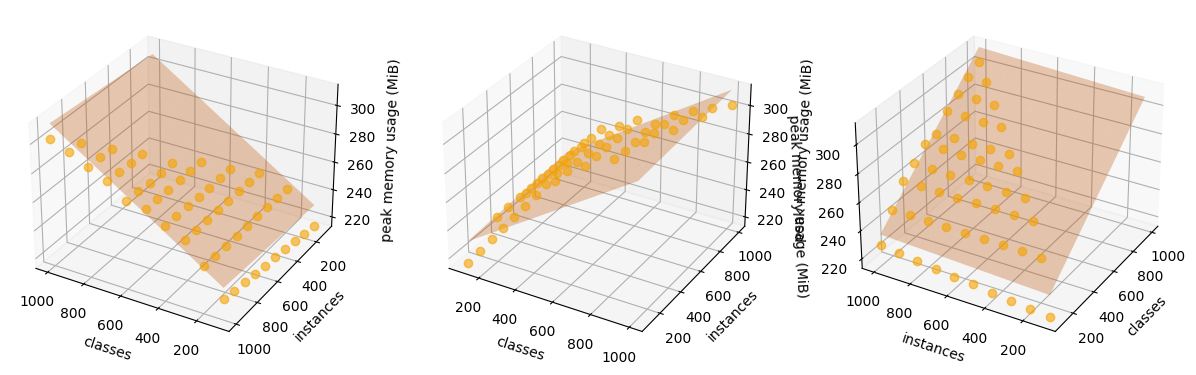

In [411]:
expC_linear_evaluation_memory("sparql")

### Infer

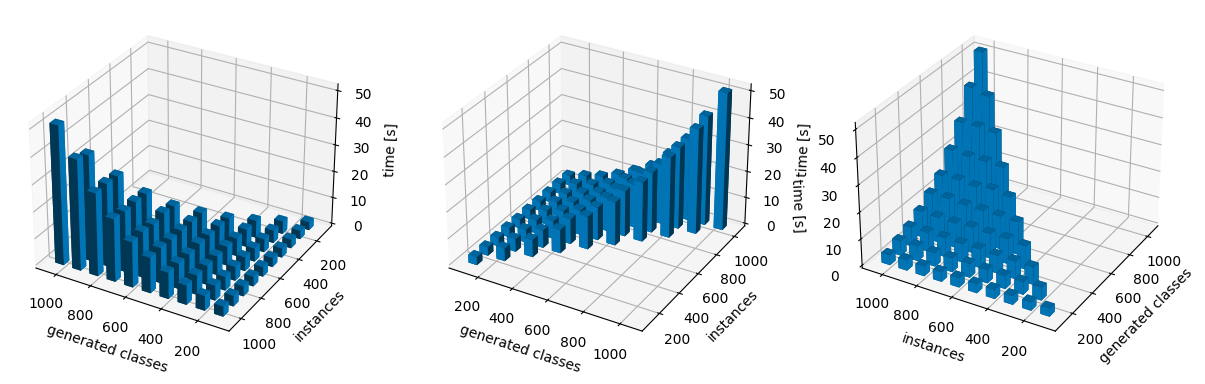

R2: 0.989160007167976
2.3578430626087155 + 4.377376292826393e-05*classes^2 + 6.934313760174257e-07*instances^2


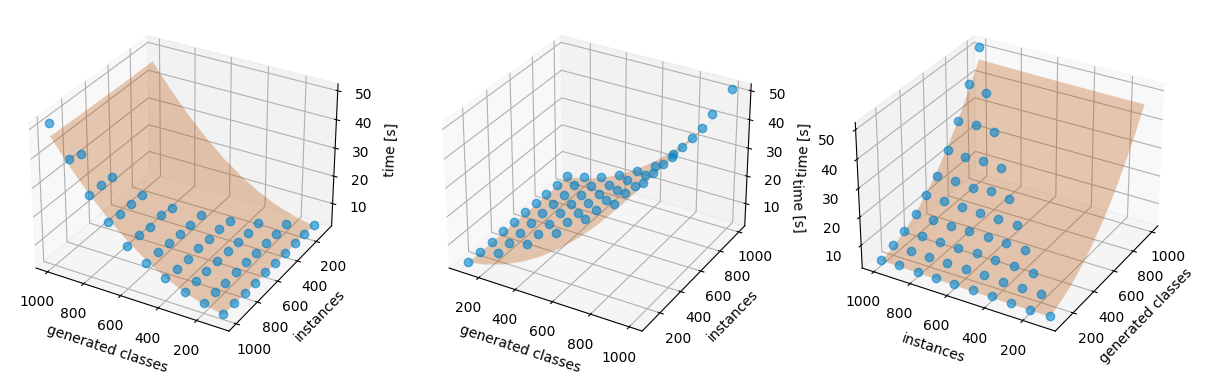

In [17]:
expC_quadratic_evaluation_time("infer")

In [524]:
cflat = flatten_for_metric(experimentCStore_times, 'times')
diag_frame = cflat['infer'].loc[[(n, 1000) for n in [100, 200, 300, 400, 500, 600, 700, 800, 1000]]].transform(
    lambda x: x.total_seconds())
display(diag_frame)
display(diag_frame.diff())
display(diag_frame.diff().diff())

100   1000     3.789188
200   1000     5.567005
300   1000     7.281636
400   1000     9.859397
500   1000    13.252204
600   1000    16.922410
700   1000    23.345273
800   1000    30.801018
1000  1000    51.345079
Name: infer, dtype: float64

100   1000          NaN
200   1000     1.777817
300   1000     1.714631
400   1000     2.577761
500   1000     3.392807
600   1000     3.670206
700   1000     6.422863
800   1000     7.455745
1000  1000    20.544061
Name: infer, dtype: float64

100   1000          NaN
200   1000          NaN
300   1000    -0.063186
400   1000     0.863130
500   1000     0.815046
600   1000     0.277399
700   1000     2.752657
800   1000     1.032882
1000  1000    13.088316
Name: infer, dtype: float64

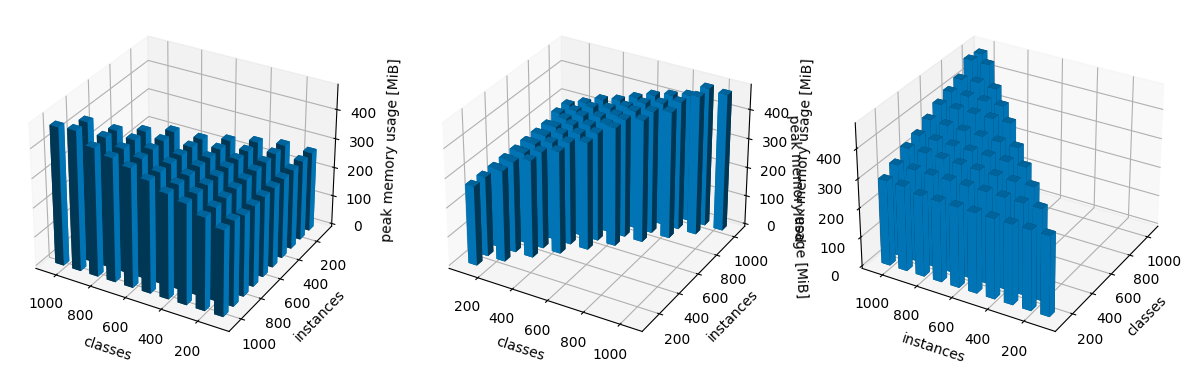

R2: 0.9855916060309533
Coefficients: [0.22003867 0.01231588]
Intercept: 257.4595705899326
Classes have stronger influence


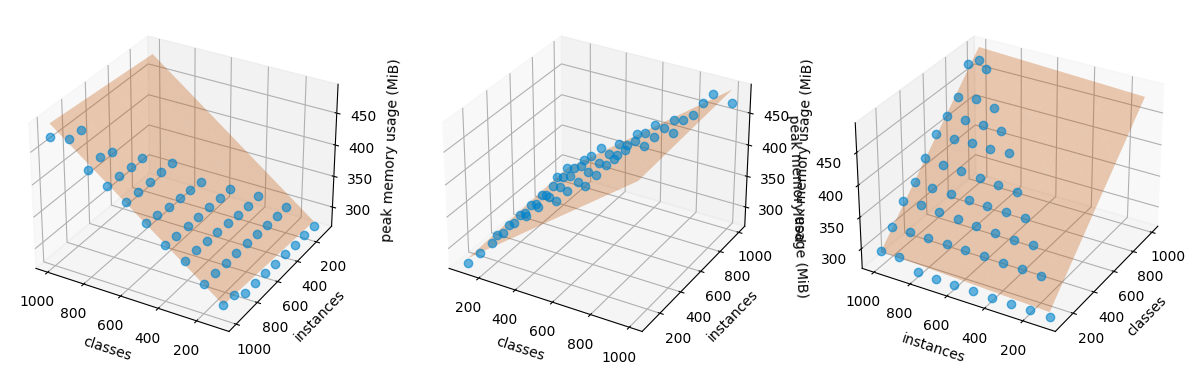

In [412]:
expC_linear_evaluation_memory("infer")

### CSV

In [71]:
save_csv(experimentCStore_memory, metric='memory', index_label=["classes", "instances"], file="experimentC_memory.csv")